# Implementation of fraud-detection algorithm using SVM in Tensorflow


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Model
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score , confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## Load data

You can download the dataset as a CSV file with a click on this [link](https://www.kaggle.com/mlg-ulb/creditcardfraud?select=creditcard.csv)

The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

 Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [2]:
credit_card = pd.read_csv('/content/drive/MyDrive/creditcard.csv',dtype=np.float32)

X = credit_card.drop(columns='Class', axis=1)
Y = credit_card['Class']

credit_card

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.619995,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660004,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798279,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.989998,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834784,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.770000,0.0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.790001,0.0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329283,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.879997,0.0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.000000,0.0


## Visualize the data

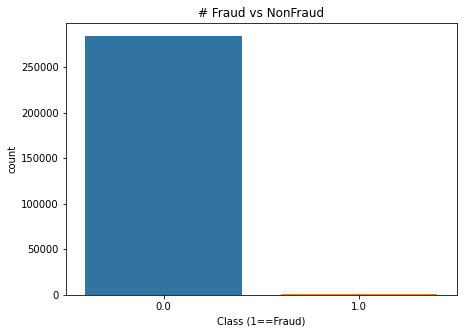

In [3]:
f, ax = plt.subplots(figsize=(7, 5))
sns.countplot(x='Class', data=credit_card)
_ = plt.title('# Fraud vs NonFraud')
_ = plt.xlabel('Class (1==Fraud)')

As we can see we have mostly non-fraudulent transactions. Such a problem is also called inbalanced class problem.
99.8% of all transactions are non-fraudulent. The easiest classifier would always predict no fraud and would be in almost all cases correct. Such classifier would have a very high accuracy but is quite useless.

As accuracy is not very informative in this case the AUC (Aera under the curve) a better metric to assess the model quality. The AUC in a two class classification class is equal to the probability that our classifier will detect a fraudulent transaction given one fraudulent and genuiune transaction to choice from. Guessing would have a probability of 50%.


## Data preparation


As preperation we standardize our features to have zero mean and a unit standard deviation. The convergence of gradient descent algorithm are better. We use the class StandardScaler. The class StandardScaler has the method fit_transform() which learn the mean $\mu_i$ and standard deviation $\sigma_i$ of each feature $i$ and return a standardized version $\frac{x_i - \mu_i}{\sigma}$. We learn the mean and sd on the training data. We can apply the same standardization on the test set with the function transform().



In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)


In SVM, we take the output 1, -1.

In [5]:
Y_train[Y_train==0] = -1
Y_test[Y_test==0]=-1

# LinearSVM Class


## What is Support Vector Machines (SVM)?

Support vector machine(SVM) is supervised learning models for classification and regression analysis.

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

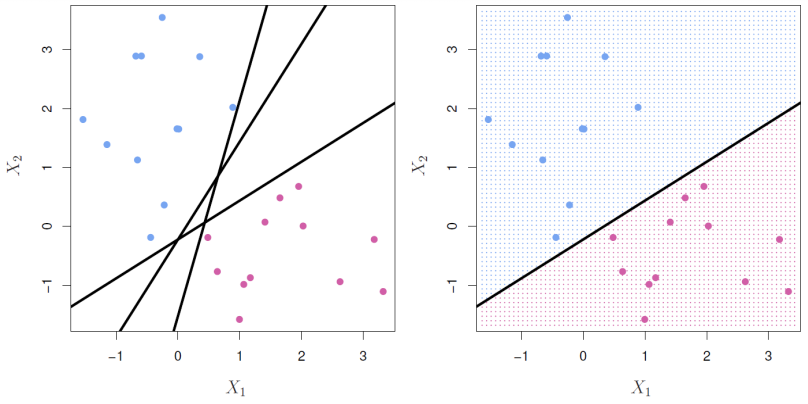

To separate the two classes of data points, there are many possible hyperplanes that could be chosen. One reasonable choice as the best hyperplane is the one that represents the largest separation, or margin, between the two classes. So we choose the hyperplane so that the distance from it to the nearest data point on each side is maximized.

Hyperplanes are decision boundaries that help classify the data points. Data points falling on either side of the hyperplane can be attributed to different classes. 

Support vectors are data points that are closer to the hyperplane and influence the position and orientation of the hyperplane.

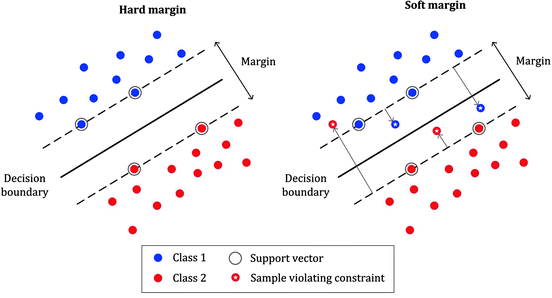

SVM can be of two types:

* Linear SVM: Linear SVM is used for linearly separable data.
* Non-linear SVM: Non-Linear SVM is used for non-linearly separated data. For non-linear SVM you can use kernel tricks shuch as Polynomial, Gaussian Radial Basis Function (RBF), Sigmoid, ... .

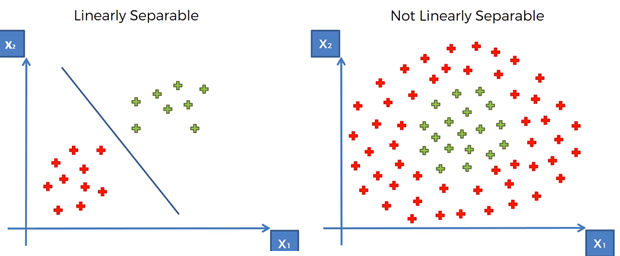

In this work, we use linear SVM algorithm(soft-margin) for the implementation of fraud detection.


Computing the (soft-margin) SVM classifier amounts to minimizing an expression of the form.

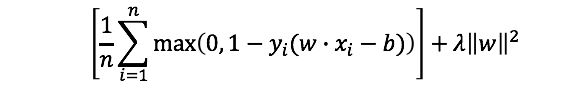

where the parameter $\lambda$  determines the trade-off between increasing the margin size and ensuring that the x_i lie on the correct side of the margin. Thus, for sufficiently small values of $\lambda$ , the second term in the loss function will become negligible, hence, it will behave similar to the hard-margin SVM.

More details are available in [Wikipedia](https://en.wikipedia.org/wiki/Support-vector_machine)


In [6]:
class LinearSVM(Model):
  def __init__(self):
    super(LinearSVM, self).__init__()
    self.w = tf.Variable(tf.random.normal([30, 1]), trainable=True , name='w')
    self.b = tf.Variable(tf.random.normal([1]), trainable=True , name='bias')
    self.alpha = tf.constant([0.0001])

    
  def predict(self, x):
    model_output = tf.subtract(tf.matmul( x , self.w), self.b)
    y_predicted = tf.sign(model_output)
    return y_predicted

  def predict_distance(self, x):
    return tf.subtract(tf.matmul( x , self.w), self.b)

  def loss(self,x,y):
    l2_norm = tf.reduce_sum(tf.square(self.w))
    model_output = tf.subtract(tf.matmul( x , self.w), self.b)
    classification_term = tf.reduce_mean(tf.maximum(0. , tf.subtract(1. , tf.multiply(model_output,y))))
    loss = tf.add(classification_term, tf.multiply(self.alpha, l2_norm))
    return loss
    
  def accuracy(self,x,y):
    pred = self.predict(x)
    accuracy = accuracy_score(y_true=y ,y_pred=pred)
    return accuracy

In [7]:
model = LinearSVM()

# Gradient descent

**Gradient descent** is a first-order iterative optimization algorithm for finding the minimum of a function. The goal of the gradient descent is to minimise a given function which, in our case, is the binary cross entropy loss function . To achieve this goal, it performs two steps iteratively:

1.   Compute the slope (gradient) that is the first-orderderivative of the function at the current point 
2.   Move-in the opposite direction of the slope increase from the current point by the computed amount

There are different ways to compute the gradient and move-in the opposite direction of gradient . Let’s look into them one by one.

# 1.  Batch Gradient Descent
In Batch Gradient Descent, all the training data is taken into consideration to take a single step. We take the average of the gradients of all the training examples and then use that mean gradient to update our parameters. So that’s just one step of gradient descent in one epoch.


One cycle through entire training datasets is called a training epoch. Therefore, it is often said that BGD performs model updates at the end of each training epoch.

It is more computationally efficient but memory consumption is too high and this happens in each and every step.


# 2. Stochastic Gradient Descent
In Batch Gradient Descent we were considering all the examples for every step of Gradient Descent. But what if our dataset is very huge. Suppose our dataset has 5 million examples, then just to take one step the model will have to calculate the gradients of all the 5 million examples. This does not seem an efficient way. To tackle this problem we have Stochastic Gradient Descent. In Stochastic Gradient Descent (SGD), we consider just one example at a time to take a single step. 

Since we are considering just one example at a time the cost will fluctuate over the training examples and it will not necessarily decrease. But in the long run, you will see the cost decreasing with fluctuations.

So, for every record, we are updating the weights and Weight updates is faster. Memory consumptions will also be low.
but because the cost is so fluctuating, it will never reach the minima but it will keep dancing around it.


# 3. Mini-Batch Gradient Descent
Batch Gradient Descent can be used for smoother curves. SGD can be used when the dataset is large. Batch Gradient Descent converges directly to minima. SGD converges faster for larger datasets. But, since in SGD we use only one example at a time, we cannot implement the vectorized implementation on it. This can slow down the computations. To tackle this problem, a mixture of Batch Gradient Descent and SGD is used. Neither we use all the dataset all at once nor we use the single example at a time. We use a batch of a fixed number of training examples which is less than the actual dataset and call it a mini-batch . 

# 4. Stochastic mini-batch Gradient descent

In Stochastic mini-batch Gradient descent we process batches of data obtained by a random permutation of the training data (i.e., each observation is processed only once per epoch, albeit in random order).Actually we should shuffle our training dataset in each epoch.
Stochastic mini batch Gradient offers the best of both worlds: computational and statistical efficiency.

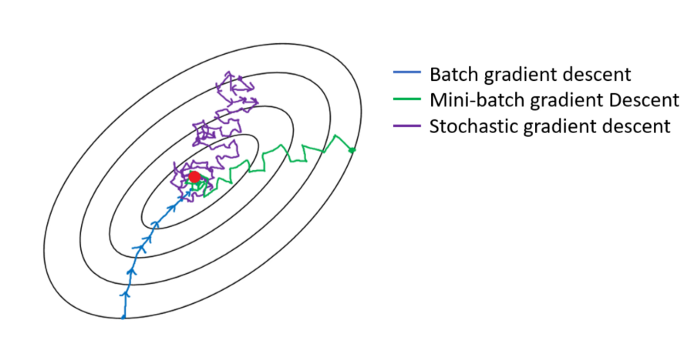



In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=.1)
n_epochs = 2
batch_size = 2048
loss_list=[]
acc_train=[]
acc_test=[]

In [9]:
def train_step(X, Y):
  with tf.GradientTape() as tape:
    loss = model.loss(x=X,y=Y)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  loss_list.append(loss)


# Stochastic Mini-batch Gradient Descent


In [10]:
for epoch in range(n_epochs):

  # Shuffle in each epoch
  index=np.random.choice(X_train.shape[0],X_train.shape[0])
  X=X_train[index,:]
  Y=np.transpose([Y_train[index]])

  for iter in range(int(X_train.shape[0]/batch_size)):

    X_train_batch = X[iter*batch_size:(iter+1)*batch_size ]
    Y_train_batch = Y[iter*batch_size:(iter+1)*batch_size]

    train_step( X_train_batch , Y_train_batch )

    acc_train.append(model.accuracy( X_train ,Y_train))
    acc_test.append(model.accuracy( X_test ,Y_test))

confusion_matrix() returns the confusion matrix, C where $C_{0,0}$ are the true negatives (TN) and $C_{0,1}$ the false positives (FP) and vice-versa for the positives in the 2nd row. We use the function accurary_score() to calculate the accuracy our models on the train and test data. We see that the accuracy is quite high (99,9%) which is expected in such an unbalanced class problem. With the method roc_auc_score()can we get the area under the receiver-operator-curve (AUC) for our simple model.

In [11]:
print("\n-------Train-------")
print(f"Train accuracy : {model.accuracy(X_train,Y_train)}")
print(f"Confusion_matrix of train set :\n {confusion_matrix(Y_train, model.predict(X_train))}")
y_train_hat_dist = model.predict_distance(X_train)
train_auc_roc = roc_auc_score(Y_train, y_train_hat_dist)*100
print(f"Training AUC: {train_auc_roc}")

print("\n-------Test-------")
print(f"Test accuracy : {model.accuracy(X_test,Y_test)}")
print( f"Confusion_matrix of test set :\n {confusion_matrix(Y_test, model.predict(X_test))}")
y_test_hat_dist  = model.predict_distance(X_test)
test_auc_roc  = roc_auc_score(Y_test, y_test_hat_dist)*100
print(f"Training AUC: {test_auc_roc }")


-------Train-------
Train accuracy : 0.9993211769387421
Confusion_matrix of train set :
 [[213183     53]
 [    92    277]]
Training AUC: 93.56085787311194

-------Test-------
Test accuracy : 0.9992556388865481
Confusion_matrix of test set :
 [[71057    22]
 [   31    92]]
Training AUC: 91.77169980453445



To visualize the Receiver-Operator-Curve we use the function roc_curve. The method returns the true positive rate (recall) and the false positive rate (probability for a false alarm) for a bunch of different thresholds. This curve shows the trade-off between recall (detect fraud) and false alarm probability.

If we classifiy all transaction as fraud, we would have a recall of 100% but also the highest false alarm rate possible (100%). The naive way to minimize the false alarm probability is to classify all transaction as legitime.

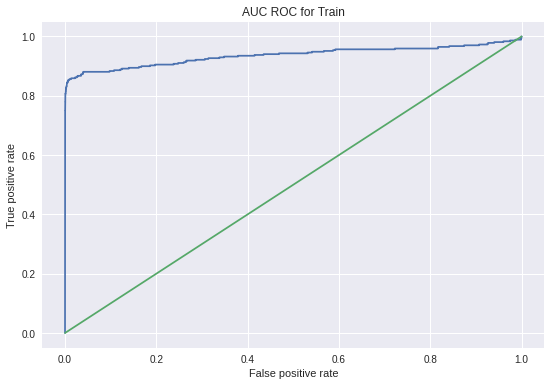

In [13]:
fpr, tpr, thresholds = roc_curve(Y_train, y_train_hat_dist, drop_intermediate=True)

f, ax = plt.subplots(figsize=(9, 6))
_ = plt.plot(fpr, tpr, [0,1], [0, 1])
_ = plt.title('AUC ROC for Train')
_ = plt.xlabel('False positive rate')
_ = plt.ylabel('True positive rate')
plt.style.use('seaborn')

plt.savefig('auc_roc.png', dpi=600)

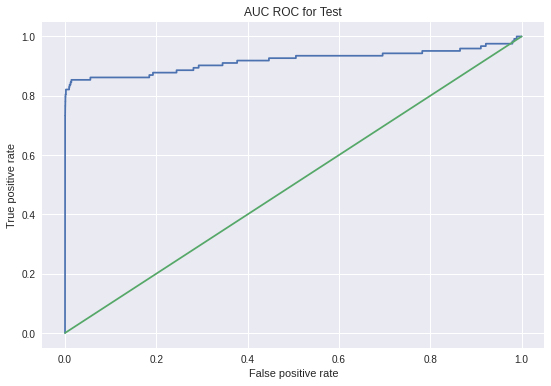

In [14]:
fpr, tpr, thresholds = roc_curve(Y_test, y_test_hat_dist, drop_intermediate=True)

f, ax = plt.subplots(figsize=(9, 6))
_ = plt.plot(fpr, tpr, [0,1], [0, 1])
_ = plt.title('AUC ROC for Test')
_ = plt.xlabel('False positive rate')
_ = plt.ylabel('True positive rate')
plt.style.use('seaborn')

plt.savefig('auc_roc.png', dpi=600)

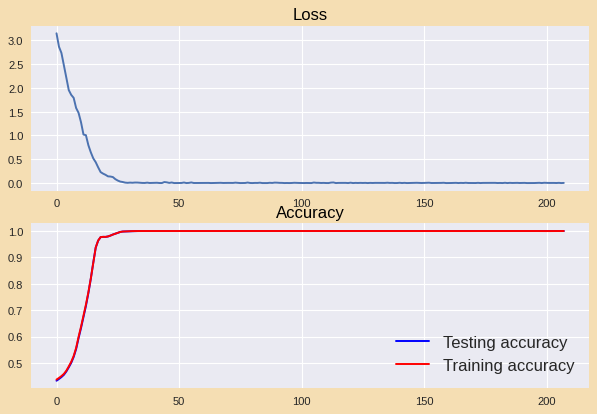

In [15]:
fig =plt.figure(figsize=(9,6),dpi=80,facecolor='wheat')

ax = fig.add_subplot(2,1, 1)
ax.plot(loss_list)
ax.set_title('Loss',color='k',size=15);


ax = fig.add_subplot(2,1, 2)
ax.plot(acc_test, color='blue',label='Testing accuracy')

ax.plot(acc_train, color='red',label='Training accuracy')
ax.legend(fontsize =15 , loc='lower right')
ax.set_title("Accuracy",color='k',size=15);